In [1]:
import numpy as np
import os
import pandas as pd
from skimage import io
from skimage import color, exposure, transform
from PIL import Image 
import cv2
import matplotlib
import matplotlib.pyplot as plt
import sys
from shutil import copyfile
from keras.callbacks import EarlyStopping
from skimage import data, img_as_float
from skimage import exposure

import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D 
from keras.layers import Input, MaxPooling2D, Dense, Dropout, Activation, Flatten, ZeroPadding2D
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras.utils import np_utils 
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.cross_validation import train_test_split

from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

Using TensorFlow backend.
/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def analyse_images(imgs_paths):
    
    data = []
    i = 0
    for img_path in imgs_paths:
        img_class = int(img_path.split('/')[-2])
        
        
        
        
        img = io.imread(img_path)
        

        # Histogram
        img_h = exposure.equalize_hist(img)
        
        data.append([img_h,img_class])
        
        i = i+1
        
        #Print every 10000 images
        if ((i % 10000)== 0):
            print ("Images processed: ")+str(i)
        
    return data




In [3]:
directory = 'CNN_scores_and_dataset/used_images/'
paths = []
number_signs = 0

if (not os.path.exists("used_images")):
    os.makedirs('used_images')

for sub_dir in os.listdir(directory):
    sd = directory+sub_dir+'/'
    if (sub_dir != ".DS_Store"):
        number_signs = number_signs+1
        images_paths = os.listdir(sd)
        np.random.shuffle(images_paths)
        for files in images_paths[:]:
            if (files.endswith(".jpg")==True):
                paths.append(directory+sub_dir+'/'+files)
                if (not os.path.exists("used_images/"+sub_dir)):
                    os.mkdir("used_images/"+sub_dir)
                copyfile(directory+sub_dir+'/'+files, 'used_images/'+sub_dir+'/'+files)



                
orig_stdout = sys.stdout
f = open('Images_used.txt', 'w')
sys.stdout = f
for img_used in paths:
    print(img_used)
    print""
sys.stdout = orig_stdout
f.close()

np.random.shuffle(paths)
data = analyse_images(paths)
elements = []
classes = []
for d in data:
    elements.append(d[0])
    classes.append(d[1])

    
direct = 'val_set_blurred/'
val_paths = []
for sub_dir in os.listdir(direct):
    sd = direct+sub_dir+'/'
    if (sub_dir != ".DS_Store"):
        for files in os.listdir(sd):
            if (files.endswith(".csv")==False) and (files.endswith(".DS_Store")==False):
                val_paths.append(direct+sub_dir+'/'+files)
                
np.random.shuffle(val_paths)
val_data = analyse_images(val_paths)
val_elements = []
val_classes = []
for vd in val_data:
    val_elements.append(vd[0])
    val_classes.append(vd[1])

/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


Images processed: 10000
Images processed: 20000
Images processed: 30000
Images processed: 40000
Images processed: 50000


In [4]:
def cnn_model(height,width,depth,number_signs):
    """
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation= 'relu',input_shape=(height, width, depth)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), data_format="channels_last"))
    model.add(Dropout(0.25))
    
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), data_format="channels_last"))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), data_format="channels_last"))
    model.add(Dropout(0.25)) 
    
              
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(number_signs, activation='softmax'))
              
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
              
    model.summary()
    
    
    return model
              
    
    
    """
    inp = Input(shape=(height, width, depth))
    #act = keras.layers.advanced_activations.ELU(alpha=0.001)
    #act= keras.layers.advanced_activations.LeakyReLU(alpha=0.001)
    conv_1 = Conv2D(32, (3, 3), padding='same')(inp)
    norm_1 = BatchNormalization()(conv_1)
    act1 = LeakyReLU(alpha=0.001)(norm_1)
    conv_2 = Conv2D(32, (3, 3), padding='same')(act1)
    norm_2 = BatchNormalization()(conv_2)
    act2 = LeakyReLU(alpha=0.001)(norm_2)
    
    pool_1 = MaxPooling2D((2, 2), data_format="channels_last")(act2)
    drop_1 = Dropout(0.2)(pool_1)

    
    conv_3 = Conv2D(64, (3, 3), padding='same')(drop_1)
    norm_3 = BatchNormalization()(conv_3)
    act3 = LeakyReLU(alpha=0.001)(norm_3)
    conv_4 = Conv2D(64, (3, 3), padding='same')(act3)
    norm_4 = BatchNormalization()(conv_4)
    act4 = LeakyReLU(alpha=0.001)(norm_4)

    pool_2 = MaxPooling2D((2, 2), data_format="channels_last")(act4)
    drop_2 = Dropout(0.2)(pool_2)
    
    conv_5 = Conv2D(128, (3, 3), padding='same')(drop_2)
    norm_5 = BatchNormalization()(conv_5)
    act5 = LeakyReLU(alpha=0.001)(norm_5)
    conv_6 = Conv2D(128, (3, 3), padding='same')(act5)
    norm_6 = BatchNormalization()(conv_6)
    act6 = LeakyReLU(alpha=0.001)(norm_6)

    pool_3 = MaxPooling2D((2, 2), data_format="channels_last")(act6)
    drop_3 = Dropout(0.2)(pool_3)
    
    
    flat = Flatten()(drop_3)
    hidden = Dense(512)(flat)
    norm_7 = BatchNormalization()(hidden)
    act7 = LeakyReLU(alpha=0.001)(norm_7)
    drop_4 = Dropout(0.5)(act7)
    out = Dense(number_signs, activation='softmax')(drop_4)

    model = Model(inputs=inp, outputs=out)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    
    
    return model
    

In [5]:
model = cnn_model(48,48,3,number_signs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 48, 48, 32)        0         
__________

In [7]:
from sklearn.cross_validation import train_test_split

batch_size = 32
nb_epochs = 50

X_train = np.array(elements, dtype='float32')
Y_train = np.eye(number_signs, dtype='uint8')[classes]
X_val = np.array(val_elements, dtype='float32')
Y_val = np.eye(number_signs, dtype='uint8')[val_classes]


datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)

datagen.fit(X_train)

#early_stopping_monitor = EarlyStopping(patience=10)
filepath = "weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

#history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),steps_per_epoch=1000,epochs=nb_epochs,callbacks=callbacks_list, validation_data=(X_val, Y_val))
history = model.fit(X_train, Y_train,batch_size=batch_size,epochs=nb_epochs,callbacks=callbacks_list, validation_data=(X_val,Y_val))
score = model.evaluate(X_val, Y_val, verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 56800 samples, validate on 2500 samples
Epoch 1/50
56800/56800 [==============================] - 1159s - loss: 0.1568 - acc: 0.9602 - val_loss: 1.0248 - val_acc: 0.7496
Epoch 2/50
56800/56800 [==============================] - 1170s - loss: 0.0113 - acc: 0.9972 - val_loss: 1.2908 - val_acc: 0.7264
Epoch 3/50
56800/56800 [==============================] - 1167s - loss: 0.0088 - acc: 0.9977 - val_loss: 1.0395 - val_acc: 0.7884
Epoch 4/50
56800/56800 [==============================] - 1167s - loss: 0.0098 - acc: 0.9972 - val_loss: 0.9964 - val_acc: 0.8080
Epoch 5/50
56800/56800 [==============================] - 1166s - loss: 0.0055 - acc: 0.9986 - val_loss: 1.1546 - val_acc: 0.7872
Epoch 6/50
56800/56800 [==============================] - 1168s - loss: 0.0035 - acc: 0.9989 - val_loss: 0.9926 - val_acc: 0.8224
Epoch 7/50
56800/56800 [==============================] - 1169s - loss: 0.0041 - acc: 0.9988 - val_loss: 1.0742 - val_acc: 0.8200
Epoch 8/50
56800/56800 [=================

56800/56800 [==============================] - 1163s - loss: 8.6747e-04 - acc: 0.9997 - val_loss: 1.3224 - val_acc: 0.8284
Epoch 32/50
56800/56800 [==============================] - 1153s - loss: 0.0010 - acc: 0.9996 - val_loss: 1.1444 - val_acc: 0.8640
Epoch 33/50
56800/56800 [==============================] - 1155s - loss: 0.0014 - acc: 0.9997 - val_loss: 1.3660 - val_acc: 0.8328
Epoch 34/50
56800/56800 [==============================] - 1154s - loss: 8.9386e-04 - acc: 0.9997 - val_loss: 1.0723 - val_acc: 0.8608
Epoch 35/50
56800/56800 [==============================] - 1156s - loss: 5.5814e-04 - acc: 0.9998 - val_loss: 1.2295 - val_acc: 0.8488
Epoch 36/50
56800/56800 [==============================] - 1156s - loss: 9.8620e-04 - acc: 0.9998 - val_loss: 1.3242 - val_acc: 0.8376
Epoch 37/50
56800/56800 [==============================] - 1156s - loss: 3.6506e-04 - acc: 0.9999 - val_loss: 2.1121 - val_acc: 0.7260
Epoch 38/50
56800/56800 [==============================] - 1158s - loss: 8.

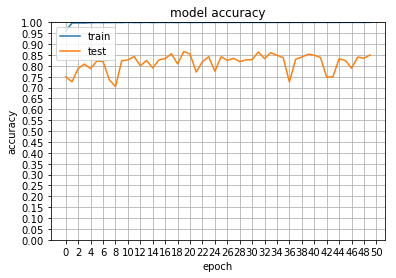

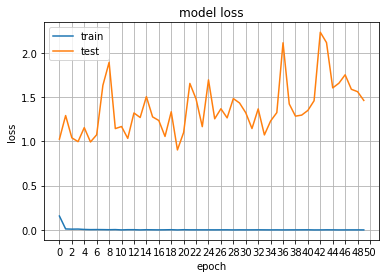

In [10]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0.0,1.0])
yintreval = np.arange(0.0, 1.05, 0.05)
xintreval = np.arange(0, 51, 2)
plt.yticks(yintreval)
plt.xticks(xintreval)
plt.grid()
fig = plt.figure()
fig.savefig('CNN -accuracy.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.xticks(xintreval)
plt.grid()
fig = plt.figure()
fig.savefig('CNN -loss.png')
plt.show()

In [11]:
orig_stdout = sys.stdout
f = open('Model_Summary.txt', 'w')
sys.stdout = f
print(model.summary())
sys.stdout = orig_stdout
f.close()

In [12]:
orig_stdout = sys.stdout
f = open('History.txt', 'w')
sys.stdout = f
print(history.history)
print('Test score:', score[0])
print('Test accuracy:', score[1])
sys.stdout = orig_stdout
f.close()

In [13]:
model.load_weights("weights.best.hdf5")
score = model.evaluate(X_val, Y_val, verbose=1)

print('Test score:', score[0])
print('Test accuracy:', score[1])

2496/2500 [============================>.] - ETA: 0s('Test score:', 0.90288997678756711)
('Test accuracy:', 0.86599999999999999)


In [14]:
from IPython.display import Image, display, SVG
from keras.utils.vis_utils import model_to_dot
import pydot
import graphviz

# Save the model as png file
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)  

In [ ]:
Y_predict = model.predict(X_val)